In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm


In [5]:
def preprocess_image(image, size=(224, 224)):
    # Resize
    image = cv2.resize(image, size)
    # Apply Gaussian Blur
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Convert to LAB color space and apply CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # Normalize
    image = image / 255.0
    return image

In [6]:
def load_data(dataset_path, size=(224, 224)):
    data = []
    labels = []
    classes = os.listdir(dataset_path)
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
                img_path = os.path.join(class_path, img_name)
                image = cv2.imread(img_path)
                if image is not None:
                    processed_image = preprocess_image(image, size)
                    data.append(processed_image)
                    labels.append(class_name)
    return np.array(data), np.array(labels)


In [7]:
def augment_and_save(data, labels, output_dir, original_class_names, size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    os.makedirs(output_dir, exist_ok=True)
    augmented_data = []
    augmented_labels = []
    
    for i, (image, label) in enumerate(zip(data, labels)):
        # Use the original class name for saving
        class_name = original_class_names[np.argmax(label)]
        label_dir = os.path.join(output_dir, class_name)
        os.makedirs(label_dir, exist_ok=True)
        
        # Expand dimensions for augmentation
        image = np.expand_dims(image, axis=0)
        counter = 0
        
        # Generate 5 augmented images per original image
        for batch in datagen.flow(image, batch_size=1):
            save_path = os.path.join(label_dir, f"{class_name}_aug_{i}_{counter}.jpg")
            cv2.imwrite(save_path, (batch[0] * 255).astype(np.uint8))
            augmented_data.append(batch[0])  # Save the augmented image in memory
            augmented_labels.append(label)  # Add corresponding label
            counter += 1
            if counter >= 15:  # Stop after generating 15 images per original image
                break
                
    return np.array(augmented_data), np.array(augmented_labels)

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_labels(labels):
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, encoder


In [9]:
def train_test_split_data(data, labels, test_size=0.2):
    return train_test_split(data, labels, test_size=test_size, random_state=42)

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers to prevent training
for layer in base_model.layers:
    layer.trainable = False


In [3]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(10, activation='softmax')(x)  # Output layer for classification

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [10]:
def train_model(model, train_data, train_labels, test_data, test_labels, epochs=20, batch_size=32):
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(test_data, test_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history


In [12]:
dataset_path = "dataset"
augmented_output_dir = "augmented_data_tl"

# Load and preprocess data
data, labels = load_data(dataset_path)
labels, encoder = encode_labels(labels)
original_class_names = encoder.classes_

# Data Augmentation
aug_data, aug_labels = augment_and_save(data, labels, augmented_output_dir, original_class_names)

# Combine original and augmented data
final_data = np.concatenate((data, aug_data), axis=0)
final_labels = np.concatenate((labels, aug_labels), axis=0)

# Train-Test Split
train_data, test_data, train_labels, test_labels = train_test_split_data(final_data, final_labels)

# Build and Train Model
input_shape = train_data.shape[1:]
num_classes = train_labels.shape[1]
history = train_model(model, train_data, train_labels, test_data, test_labels)

Processing virat_kohli: 100%|█████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.67it/s]


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.1033 - loss: 2.5260 - val_accuracy: 0.1826 - val_loss: 2.2448
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.1331 - loss: 2.3425 - val_accuracy: 0.2675 - val_loss: 2.2102
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.1504 - loss: 2.2661 - val_accuracy: 0.3185 - val_loss: 2.1777
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.1691 - loss: 2.2281 - val_accuracy: 0.3333 - val_loss: 2.1461
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.2001 - loss: 2.1916 - val_accuracy: 0.3652 - val_loss: 2.1155
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.2345 - loss: 2.1400 - val_accuracy: 0.3673 - val_loss: 2.0815
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.2541 - loss: 2.1044 - val_accuracy: 0.4055 - val_loss: 2.0517
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.2916 - loss: 2.0715 - val_accuracy: 0.4055 - v

In [13]:
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.5477 - loss: 1.5567 - val_accuracy: 0.7346 - val_loss: 1.1869
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.7222 - loss: 1.0900 - val_accuracy: 0.8174 - val_loss: 0.8412
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8119 - loss: 0.7740 - val_accuracy: 0.8896 - val_loss: 0.5734
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.8764 - loss: 0.5346 - val_accuracy: 0.9342 - val_loss: 0.4160
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.9121 - loss: 0.4011 - val_accuracy: 0.9533 - val_loss: 0.3119
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.9473 - loss: 0.2901 - val_accuracy: 0.9745 - val_loss: 0.2183
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.9487 - loss: 0.2275 - val_accuracy: 0.9745 - val_loss: 0.1602
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.9747 - loss: 0.1686 - val_accuracy: 0.9788 - v

In [14]:
model.save("tl_model.h5")

In [15]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("tl_model.h5")


In [16]:
def preprocess_new_image(image_path, size=(224, 224)):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, size)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        image = image / 255.0
        return np.expand_dims(image, axis=0)  # Add batch dimension
    else:
        print(f"Could not read the image from {image_path}")
        return None

In [17]:
import os

# Path to the dataset
dataset_path = "dataset"

# Get the class names (subfolder names)
class_names = sorted(os.listdir(dataset_path))  # Sort to ensure consistent order
class_to_index = {name: idx for idx, name in enumerate(class_names)}
index_to_class = {idx: name for name, idx in class_to_index.items()}

print("Class to Index Mapping:", class_to_index)
print("Index to Class Mapping:", index_to_class)


Class to Index Mapping: {'shikhar_dhawan': 0, 'shimron_hetmyer': 1, 'shoaib_malik': 2, 'steve_smith': 3, 'tabraiz_shamsi': 4, 'thisara_perera': 5, 'tom_curran': 6, 'trent_boult': 7, 'vijay_shankar': 8, 'virat_kohli': 9}
Index to Class Mapping: {0: 'shikhar_dhawan', 1: 'shimron_hetmyer', 2: 'shoaib_malik', 3: 'steve_smith', 4: 'tabraiz_shamsi', 5: 'thisara_perera', 6: 'tom_curran', 7: 'trent_boult', 8: 'vijay_shankar', 9: 'virat_kohli'}


In [18]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9900 - loss: 0.0872
Test Accuracy: 99.15%


In [24]:
# Predict on new images
new_image_path = "dhawanheadshot-min.jpg"
preprocessed_image = preprocess_new_image(new_image_path)
if preprocessed_image is not None:
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction)
    predicted_class_name = index_to_class[predicted_class]
    print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Predicted Class: shikhar_dhawan


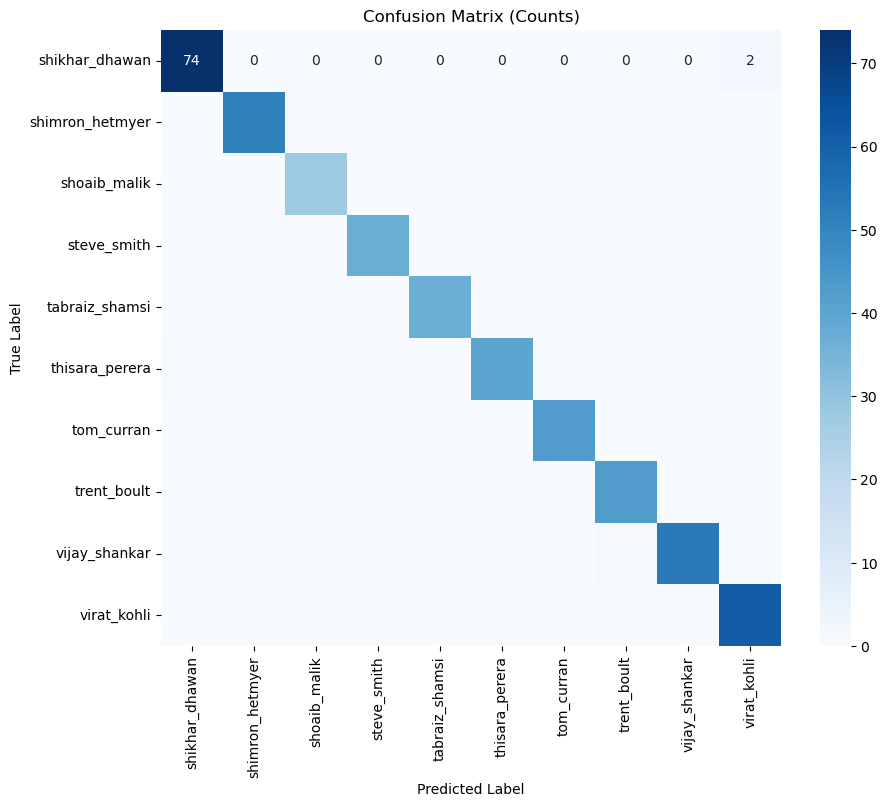

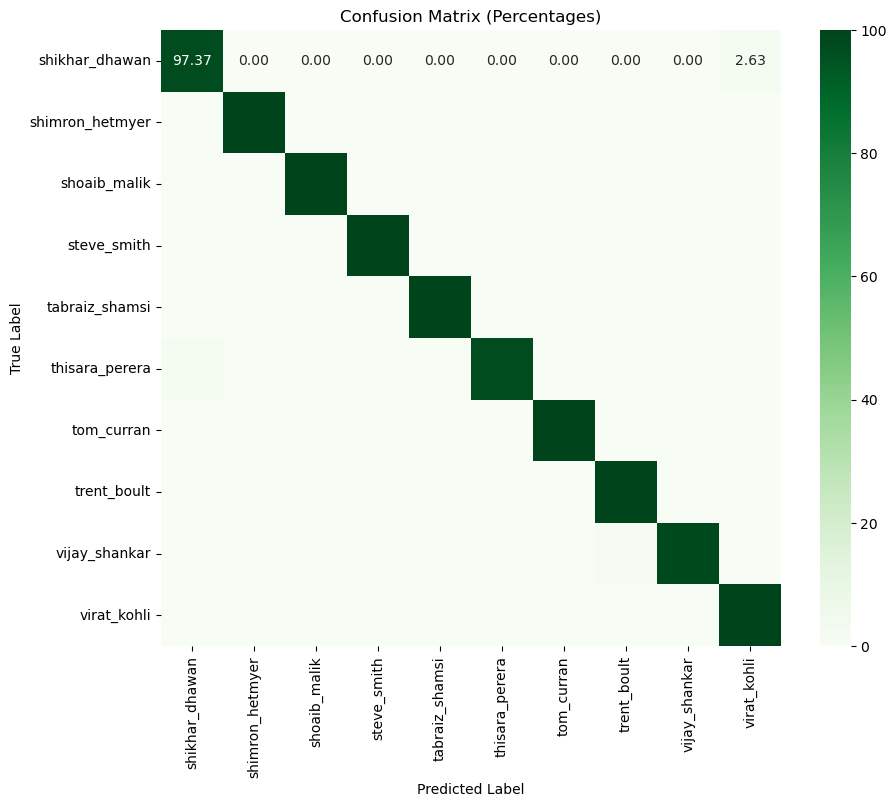


Detailed Confusion Matrix Breakdown:
Class 'shikhar_dhawan':
  True Positives: 74
  False Positives: 1
  False Negatives: 2
  True Negatives: 394

Class 'shimron_hetmyer':
  True Positives: 51
  False Positives: 0
  False Negatives: 0
  True Negatives: 420

Class 'shoaib_malik':
  True Positives: 28
  False Positives: 0
  False Negatives: 0
  True Negatives: 443

Class 'steve_smith':
  True Positives: 37
  False Positives: 0
  False Negatives: 0
  True Negatives: 434

Class 'tabraiz_shamsi':
  True Positives: 37
  False Positives: 0
  False Negatives: 0
  True Negatives: 434

Class 'thisara_perera':
  True Positives: 40
  False Positives: 0
  False Negatives: 1
  True Negatives: 430

Class 'tom_curran':
  True Positives: 43
  False Positives: 0
  False Negatives: 0
  True Negatives: 428

Class 'trent_boult':
  True Positives: 43
  False Positives: 1
  False Negatives: 0
  True Negatives: 427

Class 'vijay_shankar':
  True Positives: 53
  False Positives: 0
  False Negatives: 1
  True 

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate percentages for readability
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

    plt.figure(figsize=(10, 8))
    
    # Plot heatmap for counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Counts)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Plot heatmap for percentages
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Percentages)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Print detailed breakdown
    print("\nDetailed Confusion Matrix Breakdown:")
    for i, class_name in enumerate(class_names):
        print(f"Class '{class_name}':")
        print(f"  True Positives: {cm[i, i]}")
        print(f"  False Positives: {cm[:, i].sum() - cm[i, i]}")
        print(f"  False Negatives: {cm[i, :].sum() - cm[i, i]}")
        print(f"  True Negatives: {cm.sum() - (cm[:, i].sum() + cm[i, :].sum() - cm[i, i])}\n")

plot_confusion_matrix(true_classes, predicted_classes, class_names)



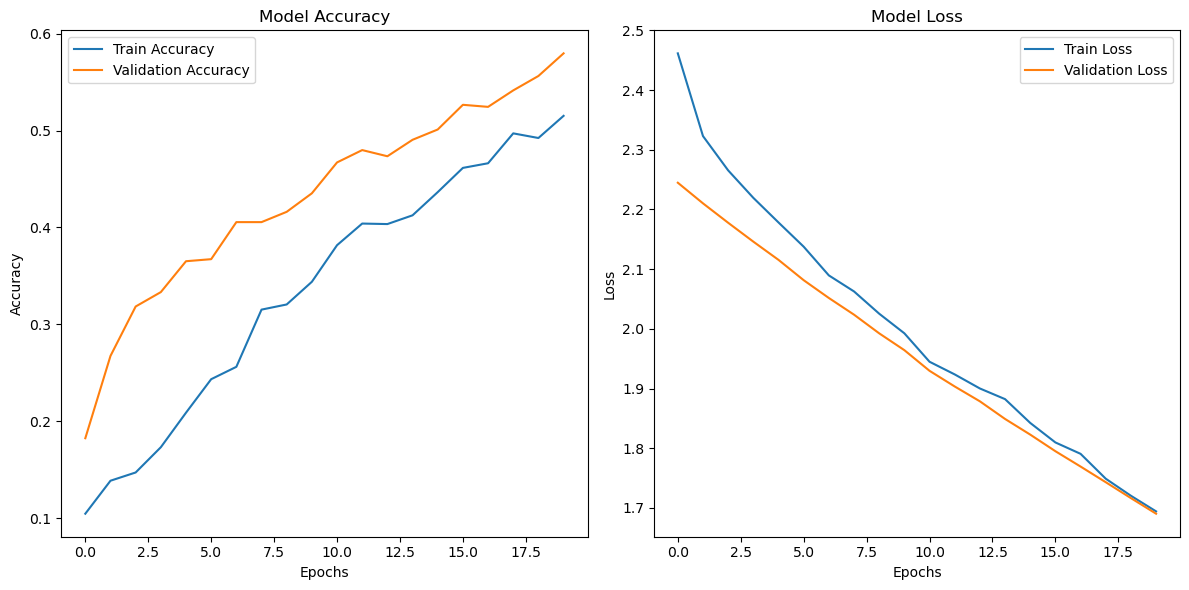

In [26]:
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
